<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 120px">

# Project 5: New York State of Energy - Renewable Energy by 2030

*Team: Muhammad Haseeb Anjum, Graham Haun, Melissa Marshall, Deval Mehta, Damar Shipp*

### Overview
According to the [New York State Energy Plan](https://energyplan.ny.gov/), the State of New York intends to reduce greenhouse gas emissions to 85% of their 1990 levels by 2050. To this end, the State must produce and maintain renewable energy infrastructure to gradually replace the existing carbon-based energy systems in place on a similar, if not accelerated, timescale. In particular, the various climatological zones of New York State are amenable to wind, solar, and hydroelectric power. In order to determine the best locations for each source of energy, we must consider a variety of factors, from typical weather to cost to land use agreements.

We employ clustering methods and time-series analysis to classify the state into these various climatological zones, so that we might simplify the process for the State Energy Planning Board to determine which land use agreements should be considered for each type of renewable energy source. We then perform a predictive time-series analysis to demonstrate that our proposed plan will continue to serve the State into the near future, in alignment with the state's benchmark goals in 2030.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from tslearn.clustering import TimeSeriesKMeans

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

## Predictive and Time-Local Climate Modeling

### Load in the Weather Data

```python
# Revert this cell to code in order to change the working directory if needed
import os

if os.getcwd() != 'pwd':
   %cd ./project-5/code

In [2]:
weather = pd.read_csv('../data/new-york-weather.csv', low_memory=False)
weather.shape

(368796, 15)

### Inspect and Handle the Weather Data

In [3]:
# Check for null values
weather.isnull().sum()

date                           0
temperature_2m_max             0
temperature_2m_min             0
daylight_duration              0
sunshine_duration              2
uv_index_max              368790
uv_index_clear_sky_max    368790
rain_sum                       0
showers_sum                    0
snowfall_sum                   0
precipitation_hours            0
wind_speed_10m_max             0
wind_gusts_10m_max             0
latitude                       0
longitude                      0
dtype: int64

In [4]:
# Check datatypes for the columns
weather.dtypes

date                      object
temperature_2m_max        object
temperature_2m_min        object
daylight_duration         object
sunshine_duration         object
uv_index_max              object
uv_index_clear_sky_max    object
rain_sum                  object
showers_sum               object
snowfall_sum              object
precipitation_hours       object
wind_speed_10m_max        object
wind_gusts_10m_max        object
latitude                  object
longitude                 object
dtype: object

In [5]:
# Drop empty columns
weather = weather.drop(columns = ['uv_index_max','uv_index_clear_sky_max'])

In [6]:
# Drop strings in the dataframe that arise from improper appendation.
weather[weather['daylight_duration'].astype(str).str.contains('day')]

,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude
5084,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude
65675,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude
126266,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude
187023,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude
247614,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude
308205,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude


In [7]:
weather = weather.drop(weather[weather['daylight_duration'].astype(str).str.contains('day')].index)

In [8]:
# SOrt the DataFrame by date
weather = weather.sort_values('date')

In [9]:
# Remove the timestamps and resultant whitespace from all dates
weather['date'] = weather['date'].str.replace('05:00:00+00:00', '')
weather['date'] = weather['date'].str.strip()

In [10]:
# Ensure feature columns are numeric
weather[['temperature_2m_max','temperature_2m_min',"daylight_duration","sunshine_duration","rain_sum",'showers_sum',
         "snowfall_sum","precipitation_hours","wind_speed_10m_max","wind_gusts_10m_max","latitude","longitude"]] = weather[['temperature_2m_max','temperature_2m_min',"daylight_duration","sunshine_duration","rain_sum",'showers_sum',
         "snowfall_sum","precipitation_hours","wind_speed_10m_max","wind_gusts_10m_max","latitude","longitude"]].apply(pd.to_numeric)

### Data Exploration

In [11]:
weather['precipitation_total'] = weather['rain_sum'] + weather['snowfall_sum'] 
weather['location'] = list(zip(weather['latitude'],weather['longitude']))

In [12]:
# Group by 'location'
grouped = weather.groupby('location')

# Drop duplicates based on 'date' for each group
weather = pd.concat([group.drop_duplicates(subset=['date']) for _, group in grouped], ignore_index=True)

# Display the first few rows of the cleaned DataFrame
weather.shape

(368790, 15)

In [13]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368790 entries, 0 to 368789
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   date                 368790 non-null  object 
 1   temperature_2m_max   368790 non-null  float64
 2   temperature_2m_min   368790 non-null  float64
 3   daylight_duration    368790 non-null  float64
 4   sunshine_duration    368788 non-null  float64
 5   rain_sum             368790 non-null  float64
 6   showers_sum          368790 non-null  float64
 7   snowfall_sum         368790 non-null  float64
 8   precipitation_hours  368790 non-null  float64
 9   wind_speed_10m_max   368790 non-null  float64
 10  wind_gusts_10m_max   368790 non-null  float64
 11  latitude             368790 non-null  float64
 12  longitude            368790 non-null  float64
 13  precipitation_total  368790 non-null  float64
 14  location             368790 non-null  object 
dtypes: float64(13), o

In [14]:
weather.isnull().sum()

date                   0
temperature_2m_max     0
temperature_2m_min     0
daylight_duration      0
sunshine_duration      2
rain_sum               0
showers_sum            0
snowfall_sum           0
precipitation_hours    0
wind_speed_10m_max     0
wind_gusts_10m_max     0
latitude               0
longitude              0
precipitation_total    0
location               0
dtype: int64

In [15]:
weather.dropna(inplace = True)
weather.head()

,date,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude,precipitation_total,location
0,2005-01-01,13.779,0.779,33603.098,29108.1450,0.0,0.0,0.00,0.0,16.781560,34.920000,40.5795,-74.1502,0.00,"(40.5795, -74.1502)"
1,2005-01-02,6.779,-1.471,33650.117,18150.7850,0.0,0.0,0.00,0.0,13.910169,31.319998,40.5795,-74.1502,0.00,"(40.5795, -74.1502)"
2,2005-01-03,12.829,6.129,33700.723,4058.1921,5.5,0.0,0.00,7.0,11.525623,27.359999,40.5795,-74.1502,5.50,"(40.5795, -74.1502)"
3,2005-01-04,9.529,2.979,33754.844,6188.0500,2.6,0.0,0.00,7.0,13.320000,40.320000,40.5795,-74.1502,2.60,"(40.5795, -74.1502)"
4,2005-01-05,3.579,0.479,33812.383,0.0000,11.5,0.0,1.33,19.0,12.727922,25.919998,40.5795,-74.1502,12.83,"(40.5795, -74.1502)"


In [16]:
weather.info() #this is after dropping those two nulls

<class 'pandas.core.frame.DataFrame'>
Index: 368788 entries, 0 to 368789
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   date                 368788 non-null  object 
 1   temperature_2m_max   368788 non-null  float64
 2   temperature_2m_min   368788 non-null  float64
 3   daylight_duration    368788 non-null  float64
 4   sunshine_duration    368788 non-null  float64
 5   rain_sum             368788 non-null  float64
 6   showers_sum          368788 non-null  float64
 7   snowfall_sum         368788 non-null  float64
 8   precipitation_hours  368788 non-null  float64
 9   wind_speed_10m_max   368788 non-null  float64
 10  wind_gusts_10m_max   368788 non-null  float64
 11  latitude             368788 non-null  float64
 12  longitude            368788 non-null  float64
 13  precipitation_total  368788 non-null  float64
 14  location             368788 non-null  object 
dtypes: float64(13), object

In [17]:
weather.isnull().sum() #nulls are removed

date                   0
temperature_2m_max     0
temperature_2m_min     0
daylight_duration      0
sunshine_duration      0
rain_sum               0
showers_sum            0
snowfall_sum           0
precipitation_hours    0
wind_speed_10m_max     0
wind_gusts_10m_max     0
latitude               0
longitude              0
precipitation_total    0
location               0
dtype: int64

Visulizations to looking at feature relationships

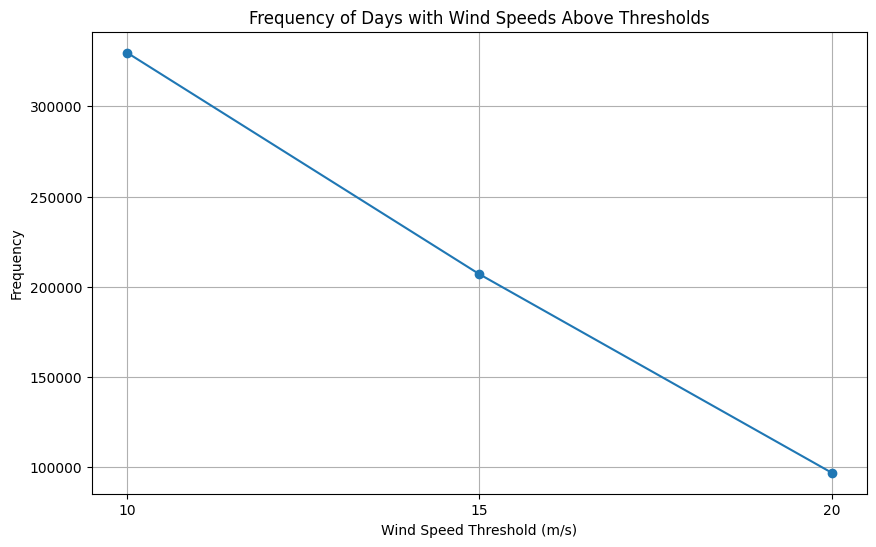

In [18]:
thresholds = [10, 15, 20]  #  thresholds
frequencies = [(weather['wind_speed_10m_max'] > t).sum() for t in thresholds]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, frequencies, marker='o')
plt.title('Frequency of Days with Wind Speeds Above Thresholds')
plt.xlabel('Wind Speed Threshold (m/s)')
plt.ylabel('Frequency')
plt.xticks(thresholds)
plt.grid(True)
plt.savefig('../images/wind_speeds_by_threshold_surpassed.png', dpi = 300)   
plt.show();

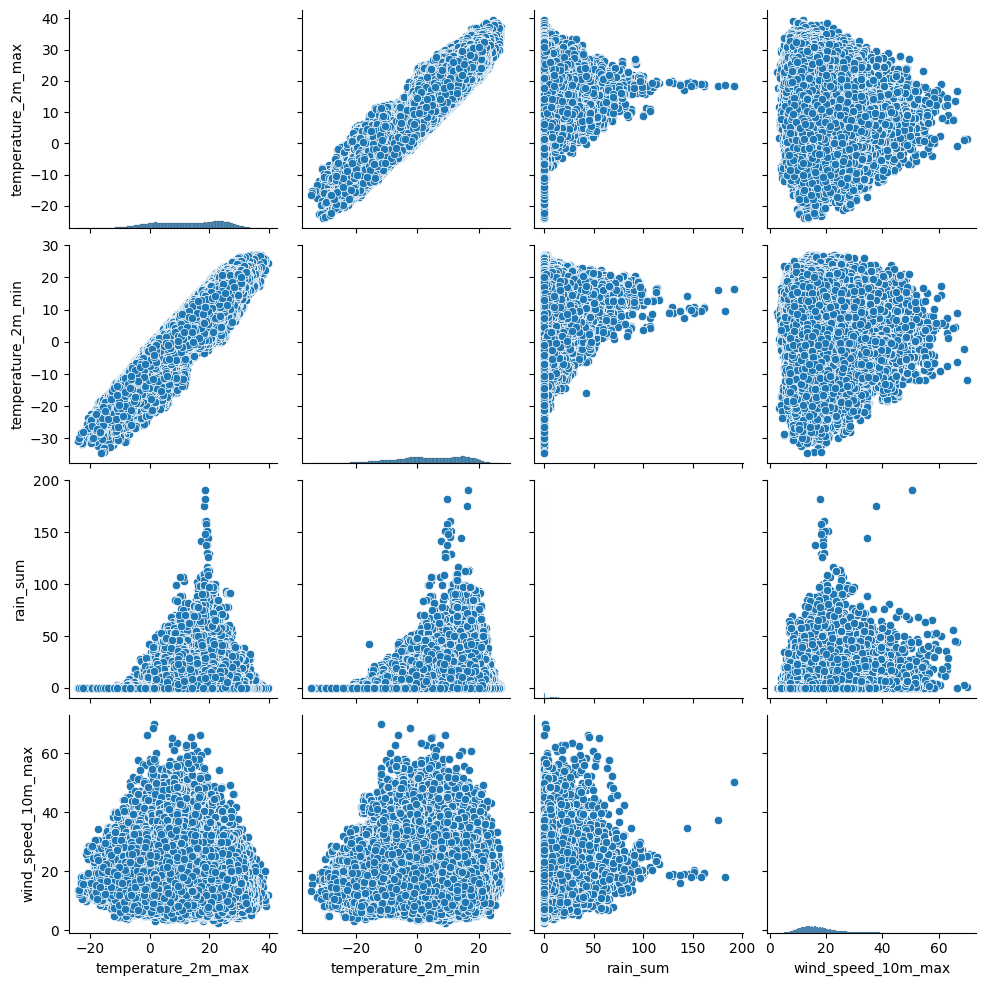

In [19]:
#looking at the feature relationships
sns.pairplot(weather[['temperature_2m_max', 'temperature_2m_min', 'rain_sum', 'wind_speed_10m_max']])
plt.savefig('../images/feature_pairplot.png', dpi = 300)
plt.show();

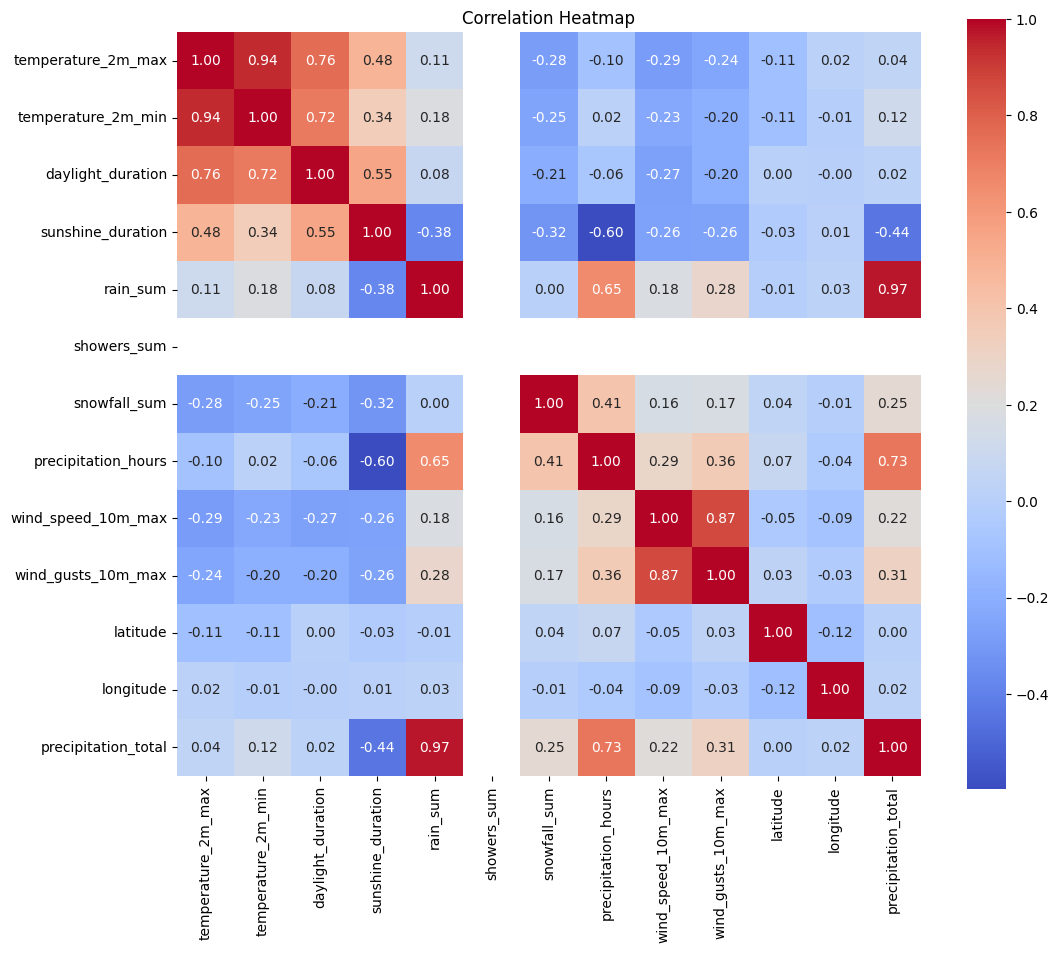

In [20]:
#identifying highly correlated features for possible feature engineering. bypassing the string conversion erro
# only the numeric columns
numeric_weather = weather.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr = numeric_weather.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))  
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap')
plt.savefig('../images/correlation_heatmap', dpi = 300)
plt.show();

In [21]:
#based on the above heat map, a few of the strongest correlations are below:

#1.'precipitation_total' and 'rain_sum'= .97 correlation so those are strong features to use
#2 'precipitation_hours' and 'rain_sum'=.65
#3 'rain_sum'= 1
#4 'sunshine_duration'=1
#5 'temperature_2m_max'=1
#6 'temperature_2m_min'=1
#7 'daylight_duration'=1
#'latiude' and 'frequency_above_20'=.96

# Calculate the correlation between 'precipitation_total' and 'rain_sum'


In [22]:
# only the numeric columns
numeric_weather = weather.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr = numeric_weather.corr()

print(corr)

                     temperature_2m_max  temperature_2m_min  \
temperature_2m_max             1.000000            0.943642   
temperature_2m_min             0.943642            1.000000   
daylight_duration              0.761975            0.717312   
sunshine_duration              0.484411            0.344992   
rain_sum                       0.113220            0.183598   
showers_sum                         NaN                 NaN   
snowfall_sum                  -0.280546           -0.248311   
precipitation_hours           -0.095704            0.018856   
wind_speed_10m_max            -0.290755           -0.231163   
wind_gusts_10m_max            -0.241997           -0.201578   
latitude                      -0.108281           -0.108601   
longitude                      0.019761           -0.007895   
precipitation_total            0.041104            0.117178   

                     daylight_duration  sunshine_duration  rain_sum  \
temperature_2m_max            0.761975        

#### Correlations Greater Than 0.5 or Less Than -0.5
Here are the correlations from above that exceed 0.5 or are below -0.5 and these indicates a strong positive or negative linear relationship. these are good to use for feature selection to improve clustering model

- temperature_2m_max and temperature_2m_min: 0.9436

- temperature_2m_max and daylight_duration: 0.7620

- temperature_2m_min and daylight_duration: 0.7173

- precipitation_total and rain_sum: 0.9696

- precipitation_hours and rain_sum: 0.6514

- wind_speed_above_20 and wind_speed_10m_max: 0.7886

- wind_speed_above_20 and wind_gusts_10m_max: 0.7064

- latitude and frequency_above_20: 0.9567

Feature Engineering

In [23]:
#thresholds
thresholds = [10, 15, 20] 

#store frequencies
wind_speed_frequencies = {}

# Calculate the frequency for each threshold
for threshold in thresholds:
    count_above_threshold = (weather['wind_speed_10m_max'] > threshold).sum()
    wind_speed_frequencies[f'wind_speed_above_{threshold}'] = count_above_threshold

# Converted to a df
wind_speed_frequency_df = pd.DataFrame.from_dict(wind_speed_frequencies, orient='index', columns=['Frequency'])

print(wind_speed_frequency_df)

                     Frequency
wind_speed_above_10     329716
wind_speed_above_15     206960
wind_speed_above_20      96932


In [24]:
# Calculate a boolean column indicating if the wind speed exceeds the threshold
weather[f'wind_speed_above_{threshold}'] = weather['wind_speed_10m_max'] > threshold

# Convert boolean to integer (1 for True, 0 for False)
weather[f'wind_speed_above_{threshold}'] = weather[f'wind_speed_above_{threshold}'].astype(int)

# Added a frequency column by summing the boolean column
weather[f'frequency_above_{threshold}'] = weather[f'wind_speed_above_{threshold}'].cumsum()

print(weather.head())

         date  temperature_2m_max  temperature_2m_min  daylight_duration  \
0  2005-01-01              13.779               0.779          33603.098   
1  2005-01-02               6.779              -1.471          33650.117   
2  2005-01-03              12.829               6.129          33700.723   
3  2005-01-04               9.529               2.979          33754.844   
4  2005-01-05               3.579               0.479          33812.383   

   sunshine_duration  rain_sum  showers_sum  snowfall_sum  \
0         29108.1450       0.0          0.0          0.00   
1         18150.7850       0.0          0.0          0.00   
2          4058.1921       5.5          0.0          0.00   
3          6188.0500       2.6          0.0          0.00   
4             0.0000      11.5          0.0          1.33   

   precipitation_hours  wind_speed_10m_max  wind_gusts_10m_max  latitude  \
0                  0.0           16.781560           34.920000   40.5795   
1                  0.0  

In [25]:
# adding a temperature range feature using two of the features that had good correlations
weather['temperature_range'] = weather['temperature_2m_max'] - weather['temperature_2m_min']

In [26]:
# average temperature
weather['average_temperature'] = (weather['temperature_2m_max'] + weather['temperature_2m_min']) / 2

In [27]:
#temperature vs daylight
weather['temp_daylight_interaction'] = weather['average_temperature'] * weather['daylight_duration']

In [28]:
#wind speed index to rep  overall wind speed conditions
weather['wind_speed_index'] = weather['wind_speed_above_20'] * weather['wind_speed_10m_max']

### Exploratory Model: $k$-Means Clustering

In [29]:
weather_km = weather.copy()
weather_km['date'] = pd.to_datetime(weather_km['date'])
df_2020 = weather_km[weather_km['date'].dt.year == 2020]
X = df_2020.drop(columns = ['date','location','rain_sum','snowfall_sum'])

pipe_km = Pipeline([
    ('sc', StandardScaler()),
    ('pca',PCA(n_components=2)),
    ('km', KMeans(n_clusters=2))
])

pipe_km.fit(X)


cluster_centers = pipe_km.named_steps['km'].cluster_centers_
centroids_pca = pipe_km.named_steps['pca'].inverse_transform(cluster_centers)
centroids = pipe_km.named_steps['sc'].inverse_transform(centroids_pca)


centroids_df = pd.DataFrame(
    centroids,
    columns=X.columns
)

In [30]:
# This showed that 5 components explaied about 91% of the variance for PCA so that was changed in the pipeline
var_exp = pipe_km['pca'].explained_variance_ratio_
np.round(var_exp[:8],3)

array([0.424, 0.229])

In [31]:
# commenting out since it takes about 5 min to run 
X_scaled_pca = pipe_km.named_steps['pca'].transform(X)
cluster_labels = pipe_km.named_steps['km'].labels_
silhouette_score(X_scaled_pca, cluster_labels)

# got a score of 0.29 since it goes from -1 to 1 this is a pretty bad score when using PCA n_components 5 and KMeans(n_clusters = 3)

0.5751507562223603

#### Scores:
- Original silhouette score: 0.29
- Raised to 0.44 by reducing n_clusters to 2
1. .407 after adding a wind speed frequency column
2. .446 after adding a temperature range column
3. .559 after adding some aggregation columns
4. .575 after adjusting the pca components to 2

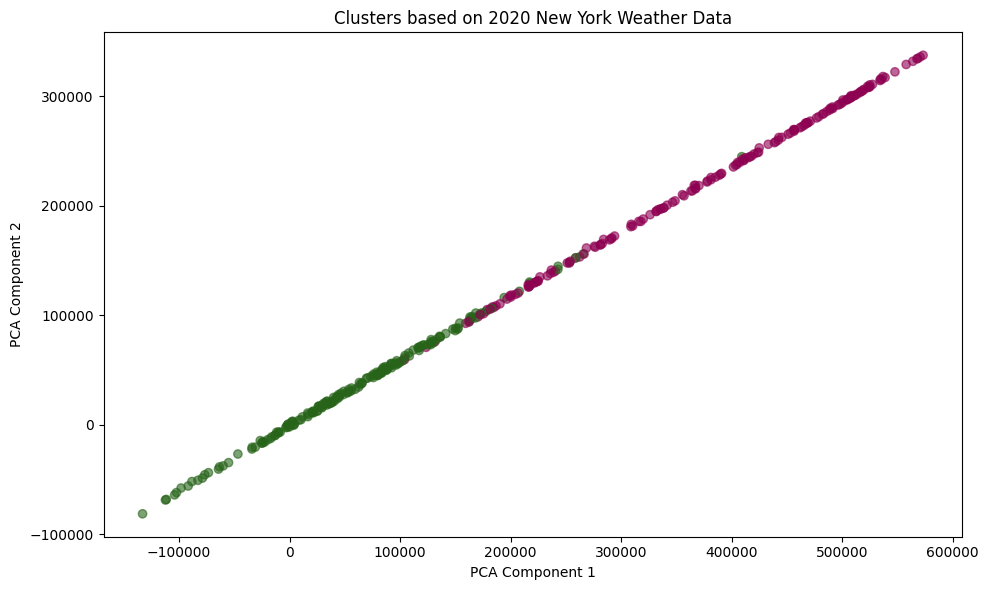

In [32]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled_pca[:, 0], X_scaled_pca[:, 1], c=cluster_labels, cmap='PiYG', alpha=0.6)
plt.title('Clusters based on 2020 New York Weather Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.tight_layout() 
plt.savefig("../images/Clusters_New_York_weather_2020.png", dpi = 300)
plt.show();

### Time Series K-Means Clustering Model

In [33]:
weather = weather.drop(columns = ['rain_sum', 'showers_sum', 'snowfall_sum'])

In [34]:
weather['date'] = pd.to_datetime(weather['date'])
weather = weather.sort_values(by = 'date')

Forecast each feature into 2030 with an ARIMA model

In [35]:
# Function to preprocess data, aggregate to monthly, and forecast with Prophet
def preprocess_and_forecast_prophet(data, forecast_end_year):
    """
    Preprocess data to monthly frequency, then forecast each feature per location 
    using Prophet out to forecast_end_year. 
    
    Returns:
        forecasted_data: np.ndarray of shape (n_locations, n_total_months, n_features)
        feature_columns: list of feature names
        all_dates: pd.DatetimeIndex corresponding to the timeline of historical + forecast
    """
    # 1. Ensure 'date' is a proper datetime
    data['date'] = pd.to_datetime(data['date'])

    # 2. Aggregate to monthly averages
    data['month'] = data['date'].dt.to_period('M')
    monthly_data = (
        data.groupby(['latitude', 'longitude', 'month'])
            .mean(numeric_only=True)
            .reset_index()
    )

    # Identify numeric feature columns
    feature_columns = [
        c for c in monthly_data.columns
        if c not in ['latitude', 'longitude', 'month']
    ]

    # Identify all unique locations
    locations = monthly_data[['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)

    # Determine the min and max month in the data
    earliest_month = monthly_data['month'].min()
    latest_month = monthly_data['month'].max()
    
    # Convert those to actual timestamps
    earliest_date = earliest_month.to_timestamp()
    latest_date = latest_month.to_timestamp()

        # Build the full date range from earliest historical date up to forecast_end_year
    all_dates = pd.date_range(
        start=earliest_date,
        end=f"{forecast_end_year}-12-01",
        freq='M'
    )

    # Prepare an array to store forecasts: shape (n_locations, len(all_dates), n_features)
    n_locs = len(locations)
    n_timestamps = len(all_dates)
    n_feats = len(feature_columns)
    forecasted_data = np.zeros((n_locs, n_timestamps, n_feats))

    for loc_idx, (lat, lon) in enumerate(locations.values):
        # Extract data for this location
        loc_df = monthly_data[
            (monthly_data['latitude'] == lat) & 
            (monthly_data['longitude'] == lon)
        ].copy()

        # Convert 'month' to datetime for Prophet
        loc_df['ds'] = loc_df['month'].dt.to_timestamp()
        loc_df.sort_values('ds', inplace=True)

        # For each feature, fit Prophet on the entire historical data and forecast
        for feat_idx, feat in enumerate(feature_columns):
            # Prepare the DataFrame for Prophet
            prophet_df = loc_df[['ds', feat]].rename(columns={feat: 'y'}).copy()
            prophet_df['y'].fillna(method='ffill', inplace=True)
            prophet_df['y'].fillna(method='bfill', inplace=True)

            model = Prophet(
                yearly_seasonality=True,
                weekly_seasonality=False,
                daily_seasonality=False
            )
            model.fit(prophet_df)

            # Create a future dataframe covering all_dates
            future_df = pd.DataFrame({'ds': all_dates})
            forecast = model.predict(future_df)

            # Align predicted 'yhat' with all_dates
            merged_forecast = pd.merge(
                future_df[['ds']], forecast[['ds', 'yhat']],
                on='ds', how='left'
            ).sort_values('ds')
            merged_forecast['yhat'].fillna(method='ffill', inplace=True)
            merged_forecast['yhat'].fillna(method='bfill', inplace=True)

            forecasted_data[loc_idx, :, feat_idx] = merged_forecast['yhat'].values

    return forecasted_data, feature_columns, all_dates, locations

In [36]:
# Define the training period to end in 2023-12 and the data extends to 2024-12
forecasted_data, feature_cols, all_dates, locations = preprocess_and_forecast_prophet(
    data=weather,
    forecast_end_year=2030
)

06:25:49 - cmdstanpy - INFO - Chain [1] start processing
06:25:50 - cmdstanpy - INFO - Chain [1] done processing
06:25:50 - cmdstanpy - INFO - Chain [1] start processing
06:25:50 - cmdstanpy - INFO - Chain [1] done processing
06:25:50 - cmdstanpy - INFO - Chain [1] start processing
06:25:51 - cmdstanpy - INFO - Chain [1] done processing
06:25:51 - cmdstanpy - INFO - Chain [1] start processing
06:25:51 - cmdstanpy - INFO - Chain [1] done processing
06:25:51 - cmdstanpy - INFO - Chain [1] start processing
06:25:51 - cmdstanpy - INFO - Chain [1] done processing
06:25:51 - cmdstanpy - INFO - Chain [1] start processing
06:25:52 - cmdstanpy - INFO - Chain [1] done processing
06:25:52 - cmdstanpy - INFO - Chain [1] start processing
06:25:52 - cmdstanpy - INFO - Chain [1] done processing
06:25:52 - cmdstanpy - INFO - Chain [1] start processing
06:25:52 - cmdstanpy - INFO - Chain [1] done processing
06:25:52 - cmdstanpy - INFO - Chain [1] start processing
06:25:53 - cmdstanpy - INFO - Chain [1]

Run a time-series k-means clustering model

In [37]:
# The shape is (n_locations, total_months, n_features)
n_locs, n_timestamps, n_feats = forecasted_data.shape

# Flatten data for clustering
reshaped_data = forecasted_data.reshape(n_locs, n_timestamps * n_feats)

# Define a pipeline for scaling, PCA, and time-series k-means
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=5)),  # Adjust as necessary
    ("kmeans", TimeSeriesKMeans(
        n_clusters=2,
        metric="softdtw",
        n_jobs=12,
        verbose=True
    ))
])

# Fit the pipeline
pipeline.fit(reshaped_data)

# Get cluster labels
clusters = pipeline.named_steps['kmeans'].labels_

9711624.901 --> 8674792.631 --> 8757924.703 --> 9167544.290 --> 9293055.227 --> 9298886.340 --> 9296324.432 --> 9295971.435 --> 9295965.508 --> 9295950.748 --> 9295950.574 --> 9295950.402 --> 9295950.402 --> 


In [75]:
scaled = pipeline.named_steps['scaler'].transform(reshaped_data)
pca_data = pipeline.named_steps['pca'].transform(scaled)
clusters = pipeline.named_steps['kmeans'].labels_

sil_score = silhouette_score(pca_data, clusters, metric='euclidean')
print("Silhouette Score:", sil_score)

Silhouette Score: 0.4341711088926885


In [76]:
def cluster_summary(forecasted_data, clusters, feature_names):
    """
    Summarize the average weather characteristics by cluster.

    Args:
        forecasted_data (np.ndarray): shape (n_locs, n_timestamps, n_features)
        clusters (np.ndarray): cluster labels of shape (n_locs,)
        feature_names (list): names of the features in the last dimension of forecasted_data
    
    Returns:
        pd.DataFrame: each row is a cluster, columns = average feature values
    """
    n_clusters = np.max(clusters) + 1
    summaries = []
    for c in range(n_clusters):
        # Indices of locations in cluster c
        idx_in_cluster = np.where(clusters == c)[0]
        
        # Subset the forecasted_data for these locations
        # shape: (n_locations_in_cluster, n_timestamps, n_features)
        data_c = forecasted_data[idx_in_cluster]
        
        # Average over both location dimension and time dimension
        # result shape: (n_features,)
        mean_features = data_c.mean(axis=(0,1))  
        
        summaries.append(mean_features)
    
    summary_df = pd.DataFrame(summaries, columns=feature_names)
    summary_df.index = [f"Cluster {i}" for i in range(n_clusters)]
    return summary_df

cluster_summary(forecasted_data, clusters, feature_cols)

,temperature_2m_max,temperature_2m_min,daylight_duration,sunshine_duration,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,precipitation_total,wind_speed_above_20,frequency_above_20,temperature_range,average_temperature,temp_daylight_interaction,wind_speed_index
Cluster 0,11.592519,3.710447,43990.903266,29180.836835,4.195193,17.419289,42.518506,2.386252,0.279949,54852.054445,7.870551,7.650727,410981.690528,6.782941
Cluster 1,14.997750,7.674667,43958.692854,29532.481679,3.575326,21.854368,42.372001,2.649169,0.372259,9876.846532,7.317464,11.338569,565597.302587,10.202225


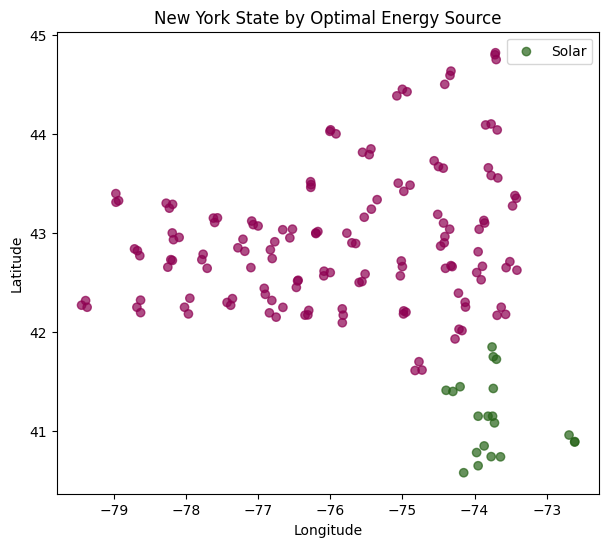

In [38]:
def plot_clusters_on_map(locations_df, cluster_assignments, title="Clusters on Map", filepath="../images/tskm_clusters.png"):
    """
    Plots each row of `locations_df` colored by its cluster assignment.

    locations_df: pd.DataFrame with columns ['latitude','longitude'], shape=(n_locs,2)
    cluster_assignments: np.ndarray of length n_locs
    """
    plt.figure(figsize=(7,6))
    scatter = plt.scatter(
        x=locations_df['longitude'],
        y=locations_df['latitude'],
        c=cluster_assignments,
        cmap='PiYG',
        alpha=0.7
    )
    plt.legend(['Solar', 'Wind'])
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title)
    plt.savefig(filepath, dpi = 300)
    plt.show();

# Now plot
plot_clusters_on_map(locations, clusters, 'New York State by Optimal Energy Source')

## Energy Load Data

### Load in the Load and Population Data

In [39]:
load_data_df = pd.read_csv('../data/Newyork_state_load_data.csv')
population_df = pd.read_csv('../data/Annual_Population_Newyork.csv')

### Inspect and Handle the Load Data

In [40]:
energy_zones_to_counties = {
    'CAPITL': [
        'Albany County', 'Schenectady County', 'Rensselaer County', 'Saratoga County',
        'Columbia County', 'Greene County', 'Washington County'
    ],
    'CENTRL': [
        'Onondaga County', 'Oswego County', 'Cayuga County', 'Cortland County',
        'Tompkins County', 'Madison County', 'Chenango County', 'Broome County'
    ],
    'DUNWOD': ['Rockland County', 'Orange County', 'Putnam County'],
    'GENESE': [
        'Monroe County', 'Genesee County', 'Livingston County', 'Ontario County',
        'Orleans County', 'Wyoming County'
    ],
    'HUD VL': [
        'Dutchess County', 'Ulster County', 'Sullivan County', 'Delaware County',
        'Schoharie County'
    ],
    'LONGIL': ['Nassau County', 'Suffolk County'],
    'MHK VL': [
        'Herkimer County', 'Oneida County', 'Montgomery County', 'Fulton County',
        'Schoharie County', 'Otsego County', 'Chenango County'
    ],
    'MILLWD': ['Westchester County'],
    'N.Y.C.': [
        'New York County', 'Bronx County', 'Queens County', 
        'Kings County', 'Richmond County'
    ],
    'NORTH': [
        'Clinton County', 'Essex County', 'Franklin County', 'Hamilton County',
        'St. Lawrence County', 'Jefferson County', 'Lewis County', 'Warren County'
    ],
    'WEST': [
        'Erie County', 'Niagara County', 'Chautauqua County', 'Cattaraugus County',
        'Allegany County', 'Steuben County', 'Chemung County', 'Tioga County',
        'Wayne County', 'Seneca County', 'Schuyler County', 'Yates County'
    ],
    'N.Y.C._LONGIL': ['Nassau County', 'Suffolk County', 'Bronx County', 'Queens County', 'Kings County']
}


In [41]:
population_df.head()

,FIPS Code,Geography,Year,Program Type,Population
0,36000,New York State,2001,Intercensal Population Estimate,19082838
1,36001,Albany County,2001,Intercensal Population Estimate,296232
2,36003,Allegany County,2001,Intercensal Population Estimate,50079
3,36005,Bronx County,2001,Intercensal Population Estimate,1346555
4,36007,Broome County,2001,Intercensal Population Estimate,200868


In [42]:
population_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575 entries, 0 to 1574
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   FIPS Code     1575 non-null   int64 
 1   Geography     1575 non-null   object
 2   Year          1575 non-null   int64 
 3   Program Type  1575 non-null   object
 4   Population    1575 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 61.6+ KB


##### *Loading the Load data of Newyork state*

In [43]:
load_data_df = pd.read_csv('../data/Newyork_state_load_data.csv')

In [44]:
load_data_df.head()

,Unnamed: 0,Name,Load,Date
0,0,CAPITL,1216.141724,2016-10-15
1,1,CENTRL,1510.761724,2016-10-15
2,2,DUNWOD,560.891034,2016-10-15
3,3,GENESE,912.815517,2016-10-15
4,4,HUD VL,920.286552,2016-10-15


In [45]:
load_data_df.drop(['Unnamed: 0'],axis=1,inplace = True)

In [46]:
load_data_df

,Name,Load,Date
0,CAPITL,1216.141724,2016-10-15
1,CENTRL,1510.761724,2016-10-15
2,DUNWOD,560.891034,2016-10-15
3,GENESE,912.815517,2016-10-15
4,HUD VL,920.286552,2016-10-15
...,...,...,...
92271,MHK VL,779.689944,2002-09-17
92272,MILLWD,211.041899,2002-09-17
92273,N.Y.C._LONGIL,9209.081006,2002-09-17
92274,NORTH,703.648045,2002-09-17


In [47]:
load_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92276 entries, 0 to 92275
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    92276 non-null  object 
 1   Load    92276 non-null  float64
 2   Date    92276 non-null  object 
dtypes: float64(1), object(2)
memory usage: 2.1+ MB


### Data Exploration

##### *Finding the Zonal-weightage of the each county according to population of each county*

In [48]:
# Initialize a list to store the results
results = []

# Iterate through each year in the population data
for year in population_df["Year"].unique():
    # Filter data for the current year
    year_data = population_df[population_df["Year"] == year]

    # Calculate zonal weightages
    for zone, counties in energy_zones_to_counties.items():
        # Filter counties in the current zone
        zone_data = year_data[year_data["Geography"].isin(counties)]
        
        # Calculate total population for the zone
        zone_population = zone_data["Population"].sum()
        
        # Calculate the weightage for each county in the zone
        for _, row in zone_data.iterrows():
            weightage = row["Population"] / zone_population if zone_population > 0 else 0
            results.append({"Year": year, "Zone": zone, "County": row["Geography"], "Weightage": weightage})

# Convert the results into a DataFrame
zonal_weightage_df = pd.DataFrame(results)

##### *Finding the Load of each county as per their Weightage*

In [49]:
# Convert the Date column in load_data_df to datetime format and extract the year
load_data_df["Date"] = pd.to_datetime(load_data_df["Date"])
load_data_df["Year"] = load_data_df["Date"].dt.year

# Merge load data with zonal weightage data on 'Year' and 'Zone'
merged_df = pd.merge(
    load_data_df.rename(columns={"Name": "Zone"}),  # Rename 'Name' to 'Zone' for consistency
    zonal_weightage_df,
    on=["Year", "Zone"],
    how="inner"
)

# Calculate the load for each county
merged_df["County Load"] = merged_df["Load"] * merged_df["Weightage"]

# Select relevant columns for the final output
county_load_df = merged_df[["Date", "County", "County Load"]]


In [50]:
county_load_df = county_load_df.groupby(["Date",'County'], as_index=False).sum()

In [51]:
county_load_df

,Date,County,County Load
0,2001-07-01,Albany County,400.786936
1,2001-07-01,Allegany County,43.408513
2,2001-07-01,Bronx County,1505.651617
3,2001-07-01,Broome County,320.510401
4,2001-07-01,Cattaraugus County,72.244372
...,...,...,...
503171,2023-12-31,Washington County,73.087174
503172,2023-12-31,Wayne County,84.145066
503173,2023-12-31,Westchester County,313.968751
503174,2023-12-31,Wyoming County,39.310160


In [52]:
county_load_df.to_csv('../data/Counties load data.csv')

##### *Pivotting the `county_load_df`*

In [53]:
# Pivot the DataFrame to make counties the columns and dates the rows
pivoted_county_load_df = county_load_df.pivot(index="Date", columns="County", values="County Load")

# Reset the index to make Date a column for easier readability
pivoted_county_load_df.reset_index(inplace=True)

In [54]:
pivoted_county_load_df.to_csv('../data/Counties load data.csv')

In [55]:
pivoted_county_load_df.columns

Index(['Date', 'Albany County', 'Allegany County', 'Bronx County',
       'Broome County', 'Cattaraugus County', 'Cayuga County',
       'Chautauqua County', 'Chemung County', 'Chenango County',
       'Clinton County', 'Columbia County', 'Cortland County',
       'Delaware County', 'Dutchess County', 'Erie County', 'Essex County',
       'Franklin County', 'Fulton County', 'Genesee County', 'Greene County',
       'Hamilton County', 'Herkimer County', 'Jefferson County',
       'Kings County', 'Lewis County', 'Livingston County', 'Madison County',
       'Monroe County', 'Montgomery County', 'Nassau County',
       'New York County', 'Niagara County', 'Oneida County', 'Onondaga County',
       'Ontario County', 'Orange County', 'Orleans County', 'Oswego County',
       'Otsego County', 'Putnam County', 'Queens County', 'Rensselaer County',
       'Richmond County', 'Rockland County', 'Saratoga County',
       'Schenectady County', 'Schoharie County', 'Schuyler County',
       'Seneca 

#### *Forecasting for the Future Years*

In [56]:
data=pd.read_csv('../data/Counties load data.csv')

In [57]:
data.head()

,Unnamed: 0,Date,Albany County,Allegany County,Bronx County,Broome County,Cattaraugus County,Cayuga County,Chautauqua County,Chemung County,...,Sullivan County,Tioga County,Tompkins County,Ulster County,Warren County,Washington County,Wayne County,Westchester County,Wyoming County,Yates County
0,0,2001-07-01,400.786936,43.408513,1505.651617,320.510401,72.244372,129.745217,120.251262,78.688168,...,174.689328,44.823998,155.506615,420.424905,88.399279,82.722038,81.300706,271.272455,41.075473,21.431648
1,1,2001-07-02,356.126787,45.096980,1288.498630,306.149810,75.054472,123.931933,124.928693,81.748913,...,142.126558,46.567524,148.539081,342.056068,88.716065,73.504226,84.463071,196.579946,41.512057,22.265277
2,2,2001-07-03,354.174723,45.640169,1276.179963,297.505475,75.958497,120.432636,126.433449,82.733572,...,143.290119,47.128426,144.344985,344.856411,88.149746,73.101322,85.480422,189.067606,41.779259,22.533461
3,3,2001-07-04,341.019445,40.866154,1204.036220,273.595114,68.013148,110.753527,113.208361,74.079543,...,145.658633,42.198737,132.744054,350.556715,86.684024,70.386086,76.539069,171.461749,38.312489,20.176434
4,4,2001-07-05,389.122565,46.643297,1476.151201,308.350258,77.627992,124.822692,129.212335,84.551977,...,170.663693,48.164264,149.606704,410.736405,88.356401,80.314523,87.359200,223.942935,44.191969,23.028725


In [58]:
data.drop(['Unnamed: 0'],axis=1,inplace=True)

In [59]:
data.head()

,Date,Albany County,Allegany County,Bronx County,Broome County,Cattaraugus County,Cayuga County,Chautauqua County,Chemung County,Chenango County,...,Sullivan County,Tioga County,Tompkins County,Ulster County,Warren County,Washington County,Wayne County,Westchester County,Wyoming County,Yates County
0,2001-07-01,400.786936,43.408513,1505.651617,320.510401,72.244372,129.745217,120.251262,78.688168,144.645462,...,174.689328,44.823998,155.506615,420.424905,88.399279,82.722038,81.300706,271.272455,41.075473,21.431648
1,2001-07-02,356.126787,45.096980,1288.498630,306.149810,75.054472,123.931933,124.928693,81.748913,140.279448,...,142.126558,46.567524,148.539081,342.056068,88.716065,73.504226,84.463071,196.579946,41.512057,22.265277
2,2001-07-03,354.174723,45.640169,1276.179963,297.505475,75.958497,120.432636,126.433449,82.733572,140.759873,...,143.290119,47.128426,144.344985,344.856411,88.149746,73.101322,85.480422,189.067606,41.779259,22.533461
3,2001-07-04,341.019445,40.866154,1204.036220,273.595114,68.013148,110.753527,113.208361,74.079543,132.253609,...,145.658633,42.198737,132.744054,350.556715,86.684024,70.386086,76.539069,171.461749,38.312489,20.176434
4,2001-07-05,389.122565,46.643297,1476.151201,308.350258,77.627992,124.822692,129.212335,84.551977,151.404471,...,170.663693,48.164264,149.606704,410.736405,88.356401,80.314523,87.359200,223.942935,44.191969,23.028725


In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8157 entries, 0 to 8156
Data columns (total 63 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 8157 non-null   object 
 1   Albany County        8157 non-null   float64
 2   Allegany County      8157 non-null   float64
 3   Bronx County         8157 non-null   float64
 4   Broome County        8157 non-null   float64
 5   Cattaraugus County   8157 non-null   float64
 6   Cayuga County        8157 non-null   float64
 7   Chautauqua County    8157 non-null   float64
 8   Chemung County       8157 non-null   float64
 9   Chenango County      8157 non-null   float64
 10  Clinton County       8157 non-null   float64
 11  Columbia County      8157 non-null   float64
 12  Cortland County      8157 non-null   float64
 13  Delaware County      8157 non-null   float64
 14  Dutchess County      8157 non-null   float64
 15  Erie County          8157 non-null   f

### Predictive 

1. [Time Series Advance Analytics techniques](https://www.advancinganalytics.co.uk/blog/2021/06/22/10-incredibly-useful-time-series-forecasting-algorithms)
2. [Prophet Method Details](https://iopscience.iop.org/article/10.1088/1742-6596/2356/1/012002/pdf#:~:text=Finally%2C%20the%20Prophet%20model%20is,the%20electricity%20load%20forecasting%20model)


##### *Converting the Date column and handeling any missing value if any*

In [61]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Fill missing values with forward-fill method
data.fillna(method='ffill', inplace=True)

##### *Defining the Prophet Forecast Model function*

In [62]:
# Function to prepare data for Prophet model
def prepare_data_for_prophet(df, date_col, value_col):
    """
    Prepares a dataframe for Prophet by renaming columns to 'ds' and 'y'.
    Args:
        df: Original dataframe
        date_col: Name of the column containing dates
        value_col: Name of the column containing the values
    Returns:
        Prepared dataframe
    """
    prepared_df = df[[date_col, value_col]].rename(columns={date_col: 'ds', value_col: 'y'})
    return prepared_df

# Function to train and forecast using Prophet
def forecast_county(data, county_name, future_years=2050):
    """
    Trains a Prophet model and forecasts future values for a given county.
    Args:
        data: Original dataframe
        county_name: Name of the county column to forecast
        future_years: Year up to which to forecast
    Returns:
        Dataframe containing forecasted values
    """
    # Prepare data for the selected county
    county_data = prepare_data_for_prophet(data, 'Date', county_name)
    
    # Initialize Prophet model
    model = Prophet()
    model.fit(county_data)
    
    # Create a dataframe for future dates
    last_date = county_data['ds'].max()
    future_dates = model.make_future_dataframe(periods=(future_years - last_date.year) * 365)
    
    # Forecast
    forecast = model.predict(future_dates)
    return forecast[['ds', 'yhat']]

##### *Applying Prophet Forecast Model for all the Counties and saving it into the file*

#### *EDA* 

In [63]:
# Load the dataset 
file_path = '../data/load_data_from_2005-01-01_to_2030-12-31.csv'  
data = pd.read_csv(file_path)

In [64]:
data.head()

,Unnamed: 0,Date,Albany County,Allegany County,Bronx County,Broome County,Cattaraugus County,Cayuga County,Chautauqua County,Chemung County,...,Sullivan County,Tioga County,Tompkins County,Ulster County,Warren County,Washington County,Wayne County,Westchester County,Wyoming County,Yates County
0,1249,2005-01-01,385.824395,47.852876,1056.999409,338.405186,78.791350,136.752769,130.515727,85.267917,...,144.447614,49.303390,167.487826,344.156429,102.616103,79.463753,89.603843,283.098020,44.070867,23.940731
1,1250,2005-01-02,382.510192,46.716039,1035.148848,335.403085,76.911964,135.536662,127.384184,83.206654,...,142.753961,48.122045,166.005928,340.115881,102.551720,78.771234,87.443372,278.036938,43.233926,23.360655
2,1251,2005-01-03,413.817753,51.964372,1159.247261,366.889046,85.550804,147.967085,141.768989,92.672260,...,152.041783,53.571452,182.129671,361.978195,104.773214,85.092993,97.489635,298.783158,48.386694,26.068266
3,1252,2005-01-04,419.693665,52.752776,1176.636881,371.400422,86.842858,149.732348,143.919363,94.085122,...,153.756477,54.390108,184.472636,365.989918,105.235669,86.266557,99.006758,302.620810,49.161575,26.478622
4,1253,2005-01-05,419.800236,52.863439,1179.582334,370.351783,87.018823,149.302272,144.210205,94.273773,...,153.957201,54.504436,183.959653,366.424916,105.417424,86.279410,99.226651,303.233173,49.233988,26.539589


In [65]:
# Dropping the Unamed: 0
data.drop('Unnamed: 0', axis =1, inplace = True)

In [66]:
# Preprocessing: Convert Date column to datetime and set as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [67]:
# Create Total Consumption column
data['Total Consumption'] = data.iloc[:, :-1].sum(axis=1)

##### *1. Seasonality Analysis: Monthly Averages*

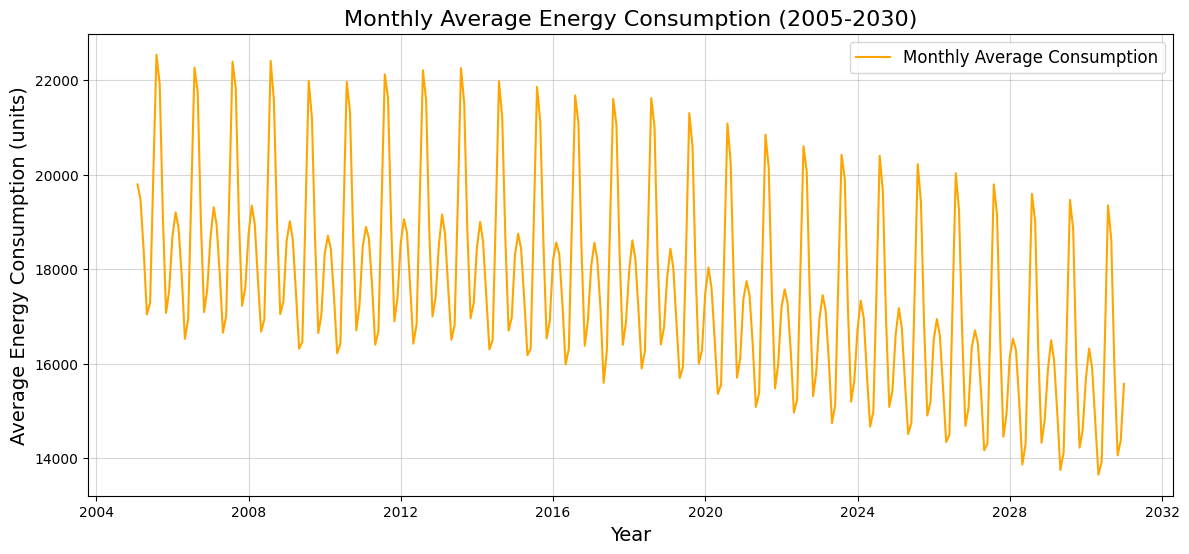

In [68]:
monthly_avg = data['Total Consumption'].resample('M').mean()
plt.figure(figsize=(14, 6))
plt.plot(monthly_avg, label='Monthly Average Consumption', color='orange')
plt.title('Monthly Average Energy Consumption (2005-2030)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Energy Consumption (units)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.savefig('../monthly_average_energy_consumption.png')
plt.show()

##### *2. County-Level Analysis: Top Consumer County in Avg Megawatts Per Day Over the Years*

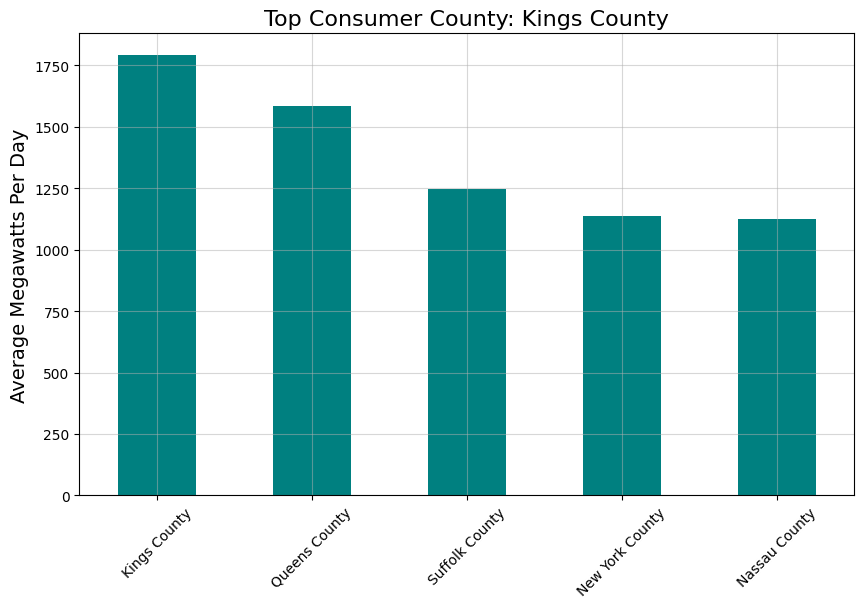

In [69]:
daily_avg = data.iloc[:, :-1].resample('D').mean().mean()
top_consumer_county = daily_avg.idxmax()
plt.figure(figsize=(10, 6))
daily_avg.sort_values(ascending=False).head(5).plot(kind='bar', color='teal')
plt.title(f'Top Consumer County: {top_consumer_county}', fontsize=16)
plt.ylabel('Average Megawatts Per Day', fontsize=14)
plt.xticks(rotation=45)
plt.grid(alpha=0.5)
plt.savefig('../images/top_consumer_county_avg_megawatts_per_day.png')
plt.show()

##### *3. Total Megawatts Per Day for the Whole State Over the Year*

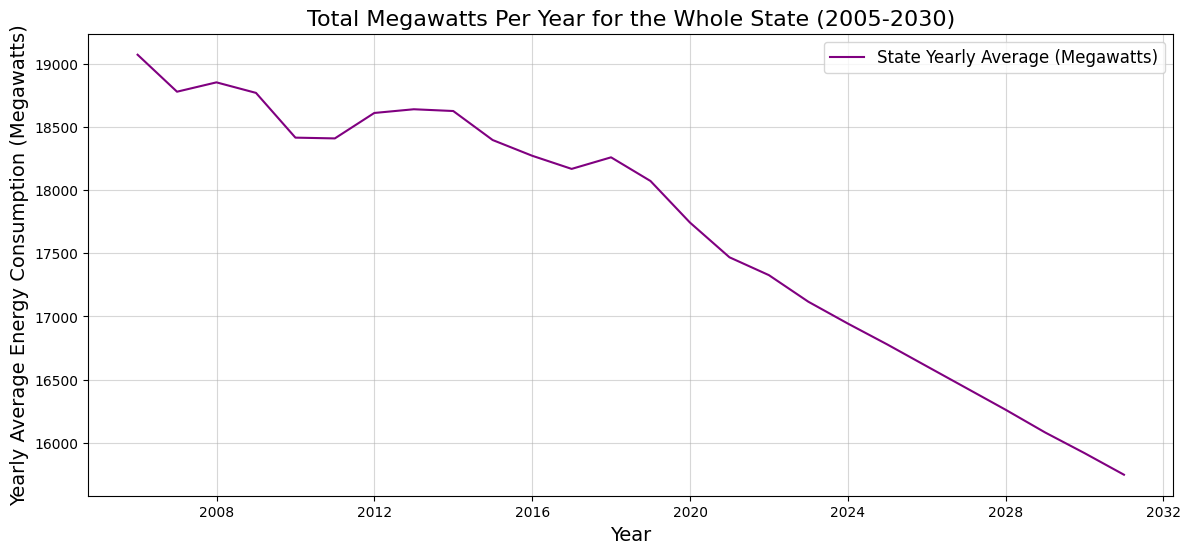

In [70]:
state_yearly_avg = data['Total Consumption'].resample('Y').mean()
plt.figure(figsize=(14, 6))
plt.plot(state_yearly_avg, label='State Yearly Average (Megawatts)', color='purple')
plt.title('Total Megawatts Per Year for the Whole State (2005-2030)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Yearly Average Energy Consumption (Megawatts)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.savefig('../images/state_yearly_avg_megawatts_per_year.png')
plt.show()

##### *4. Comparing Past and Predicted Trends*

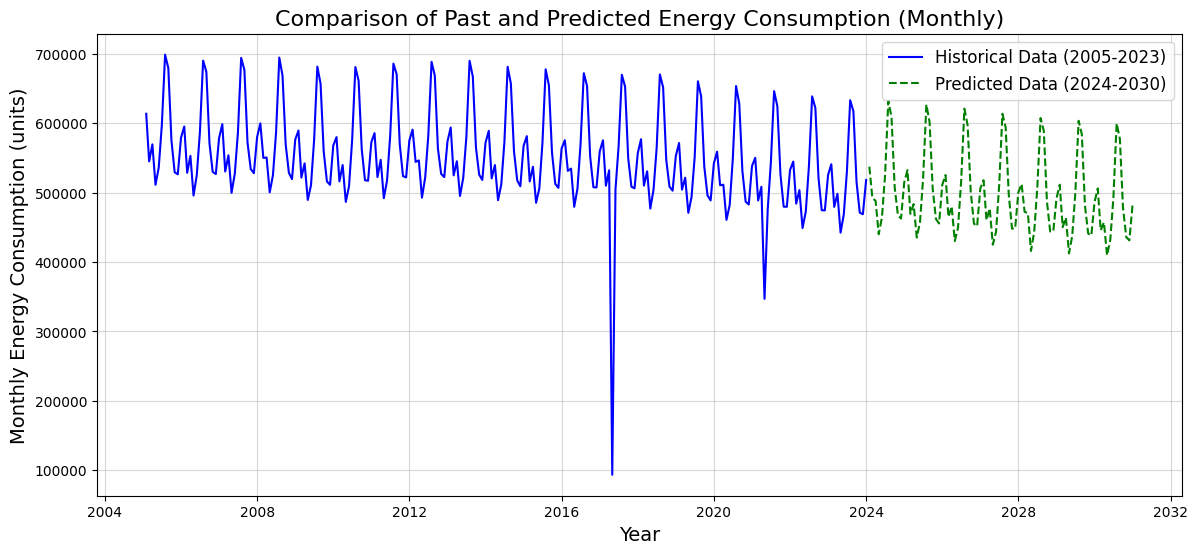

In [71]:
past_monthly_data = data.loc[data.index < '2024-01-01', 'Total Consumption'].resample('M').sum()
future_monthly_data = data.loc[data.index >= '2024-01-01', 'Total Consumption'].resample('M').sum()

plt.figure(figsize=(14, 6))
plt.plot(past_monthly_data, label='Historical Data (2005-2023)', color='blue')
plt.plot(future_monthly_data, label='Predicted Data (2024-2030)', color='green', linestyle='--')
plt.title('Comparison of Past and Predicted Energy Consumption (Monthly)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Monthly Energy Consumption (units)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.savefig('../images/past_vs_predicted_monthly_energy_consumption.png')
plt.show()

### Findings and Implications


### Next Steps
Confirm that our proposal accurately assesses and meets New York's energy needs through 2050.